In [605]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import neighbors, preprocessing
import numpy as np

RAW_USRLIST = "./dataset2/300User.txt"
RAW_WSLIST = "./dataset2/500WS.txt"
RAW_TPMATRIX = "./dataset2/tpMatrix"
RAW_RTMATRIX = "./dataset2/rtMatrix"

UserMatrix = pd.read_csv(RAW_USRLIST, sep='\t', header=None)
WSMatrix = pd.read_csv(RAW_WSLIST, sep='\t', header=None)
TPMatrix = pd.read_csv(RAW_TPMATRIX, sep='\t', header=None)
RTMatrix = pd.read_csv(RAW_RTMATRIX, sep='\t', header=None)
# TPMatrix.drop(TPMatrix.shape[1] - 1, axis=1, inplace=True)
# RTMatrix.drop(RTMatrix.shape[1] - 1, axis=1, inplace=True)

# for table in [ UserMatrix, WSMatrix ]:
#     table.rename(
#         columns={ origin: origin[1:-1] for origin in table.columns },
#         inplace=True
#     )

In [606]:
NUM_USER_TRAIN = 299
NUM_USER_TEST = 1
NUM_SERVICE = 500
K = 60

In [607]:
UserMatrix.head()

,0,1
0,12.108.127.138,UnitedStates
1,12.46.129.15,UnitedStates
2,122.1.115.91,Japan
3,128.10.19.52,UnitedStates
4,128.10.19.53,UnitedStates


In [608]:
UserMatrix.shape

(300, 2)

In [609]:
WSMatrix.head()

,0,1
0,http://orange-cagnes.dyndns.org/axis/services/...,France
1,http://aquest.dyndns.org/CaptchaAudioWS/Captch...,Japan
2,http://insolution.dyndns.org/WebService1/Servi...,Finland
3,http://dinoch.dyndns.org:7070/axis1.2/services...,United States
4,http://dinoch.dyndns.org:7070/axis1.2/services...,United States


In [610]:
WSMatrix.shape

(500, 2)

In [611]:
TPMatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,17.543,25.316,9.049,9.009,4.415,189.045,5.181,4.622,0.370,7.358,...,0.243,0.492,0.327,0.896,0.248,0.987,0.653,2.344,9.168,5.372
1,15.267,21.978,7.968,7.874,3.067,166.666,4.555,4.166,4.705,26.666,...,0.680,0.507,0.723,1.067,0.739,1.282,5.154,3.508,69.597,10.992
2,10.928,15.957,5.602,5.586,3.081,109.183,3.115,2.473,3.012,22.897,...,0.408,0.342,0.187,0.362,0.368,1.650,8.620,1.705,36.445,20.897
3,17.699,25.751,9.090,9.132,2.614,134.930,5.390,5.434,5.037,11.299,...,3.649,2.205,3.389,5.802,4.081,1.103,7.736,5.102,61.755,33.630
4,17.621,25.751,9.090,9.049,2.392,123.986,5.376,4.846,5.617,11.703,...,2.197,1.125,2.328,3.778,2.181,1.029,5.383,3.067,55.447,34.034


In [612]:
# In order to mimic the missing data, generate sparse matrix by sampling
RTSparse = RTMatrix.apply(lambda row : row.sample(frac=0.5, random_state=row.name), axis=1)
TPSparse = TPMatrix.apply(lambda row : row.sample(frac=0.5, random_state=row.name), axis=1)
TPSparse.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,NaN,25.316,9.049,NaN,4.415,189.045,5.181,4.622,0.370,NaN,...,0.243,0.492,0.327,0.896,NaN,NaN,0.653,NaN,NaN,5.372
1,15.267,NaN,NaN,NaN,3.067,166.666,4.555,NaN,NaN,26.666,...,NaN,0.507,0.723,NaN,NaN,1.282,5.154,NaN,NaN,10.992
2,NaN,15.957,5.602,5.586,NaN,NaN,3.115,2.473,NaN,NaN,...,0.408,0.342,NaN,NaN,NaN,NaN,8.620,NaN,36.445,NaN
3,NaN,NaN,NaN,9.132,2.614,134.930,5.390,NaN,NaN,NaN,...,3.649,2.205,NaN,NaN,NaN,NaN,7.736,5.102,NaN,NaN
4,NaN,25.751,NaN,NaN,NaN,NaN,5.376,NaN,5.617,NaN,...,2.197,1.125,2.328,3.778,NaN,1.029,5.383,NaN,NaN,34.034


In [613]:
# kendall distance of 10 users
# kendallSim = RTSparse[0:10].T.corr(method='kendall')
# plt.matshow(kendallSim, cmap=plt.cm.gray)
# kendallSim

In [614]:
# kendallSim.apply(lambda row: np.sign(row - 0.5))

In [615]:
# Train & Test set
tpTrain, tpTest = TPSparse[NUM_USER_TEST:], TPSparse[:NUM_USER_TEST]
# rtTrain, rtTest = RTSparse[:NUM_USER_TRAIN], RTSparse[-NUM_USER_TEST:]
tpTrain.index = range(0, NUM_USER_TRAIN)
rtTest.index = range(1)
tpTrain

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,15.267,NaN,NaN,NaN,3.067,166.666,4.555,NaN,NaN,26.666,...,NaN,0.507,0.723,NaN,NaN,1.282,5.154,NaN,NaN,10.992
1,NaN,15.957,5.602,5.586,NaN,NaN,3.115,2.473,NaN,NaN,...,0.408,0.342,NaN,NaN,NaN,NaN,8.620,NaN,36.445,NaN
2,NaN,NaN,NaN,9.132,2.614,134.930,5.390,NaN,NaN,NaN,...,3.649,2.205,NaN,NaN,NaN,NaN,7.736,5.102,NaN,NaN
3,NaN,25.751,NaN,NaN,NaN,NaN,5.376,NaN,5.617,NaN,...,2.197,1.125,2.328,3.778,NaN,1.029,5.383,NaN,NaN,34.034
4,15.936,NaN,NaN,8.368,2.232,NaN,4.750,NaN,NaN,15.800,...,2.587,NaN,NaN,3.307,2.395,NaN,6.920,4.854,NaN,NaN
5,16.326,NaN,8.438,NaN,2.244,116.430,4.651,NaN,5.291,NaN,...,NaN,NaN,NaN,NaN,5.464,1.007,NaN,3.125,NaN,41.820
6,NaN,NaN,8.230,7.518,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.329,5.893,4.854,NaN,NaN,4.866,94.370,NaN
7,18.867,NaN,NaN,10.000,4.395,149.441,NaN,NaN,5.747,NaN,...,3.220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.668,NaN
8,NaN,NaN,10.000,NaN,3.344,NaN,5.882,6.097,NaN,27.368,...,NaN,0.771,NaN,2.909,2.339,1.169,NaN,3.676,NaN,39.260
9,NaN,20.408,7.575,NaN,NaN,NaN,4.192,0.507,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.302,NaN,NaN,10.083,NaN


In [616]:
# Acutal
GT_TP_TEST = TPMatrix[:NUM_USER_TEST]
# GT_RT_TEST = RTMatrix[-NUM_USER_TEST:]
GT_TP_TEST

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,17.543,25.316,9.049,9.009,4.415,189.045,5.181,4.622,0.37,7.358,...,0.243,0.492,0.327,0.896,0.248,0.987,0.653,2.344,9.168,5.372


In [617]:
tpTrainNotNAN = np.where(~np.isnan(tpTrain.values[0]))
tpTestNotNAN = np.where(~np.isnan(tpTest.values.ravel()))

In [618]:
np.intersect1d(tpTrainNotNAN, tpTestNotNAN)

array([  4,   5,   6,  12,  14,  17,  18,  46,  51,  59,  65,  66,  78,
        81,  89,  90,  92,  93, 101, 102, 106, 107, 112, 120, 122, 124,
       132, 135, 142, 145, 146, 150, 157, 159, 164, 167, 168, 171, 173,
       179, 186, 188, 191, 206, 208, 213, 221, 224, 225, 230, 232, 233,
       236, 238, 245, 246, 247, 249, 250, 261, 272, 283, 284, 289, 293,
       295, 298, 300, 306, 310, 311, 312, 320, 322, 325, 326, 329, 330,
       331, 340, 342, 343, 344, 347, 360, 364, 365, 372, 374, 375, 379,
       401, 406, 407, 415, 421, 422, 425, 427, 428, 430, 433, 438, 450,
       451, 455, 458, 463, 469, 475, 479, 485, 488, 491, 492, 496, 499])

In [619]:
np.union1d(tpTrainNotNAN, tpTestNotNAN)

array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  29,
        30,  31,  33,  34,  37,  38,  39,  40,  41,  45,  46,  47,  49,
        51,  52,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  78,  80,  81,
        82,  85,  88,  89,  90,  91,  92,  93,  95,  96,  98, 100, 101,
       102, 103, 105, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117,
       118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147,
       150, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       167, 168, 170, 171, 172, 173, 174, 175, 176, 179, 180, 181, 185,
       186, 187, 188, 189, 190, 191, 192, 194, 196, 197, 198, 200, 201,
       204, 205, 206, 207, 208, 210, 213, 214, 218, 219, 220, 221, 223,
       224, 225, 229, 230, 231, 232, 233, 235, 236, 238, 239, 24

In [620]:
# w = len(np.intersect1d(tpTrainNotNAN, tpTestNotNAN)) / len(np.union1d(tpTrainNotNAN, tpTestNotNAN))

In [621]:
def calWeigth(u, v):
    uIndices, vIndices = np.where(~np.isnan(u)), np.where(~np.isnan(v))
    intersect = np.intersect1d(uIndices, vIndices)
    union = np.union1d(uIndices, vIndices)
    return len(intersect) / len(union)
weight_u_v = tpTrain.apply(lambda u: calWeigth(u, tpTest), axis=1)
weight_u_v

0      0.308094
1      0.321900
2      0.346774
3      0.350404
4      0.357724
         ...   
294    0.325397
295    0.325397
296    0.350404
297    0.332447
298    0.318421
Length: 299, dtype: float64

In [622]:
# tpTrain - np.dot(tpTest.T, np.array([1] * NUM_USER_TRAIN).reshape(1, -1)
tpTestReplica = tpTest.append([tpTest]* (NUM_USER_TRAIN - NUM_USER_TEST), ignore_index=True)
tpTestReplica.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,NaN,25.316,9.049,NaN,4.415,189.045,5.181,4.622,0.37,NaN,...,0.243,0.492,0.327,0.896,NaN,NaN,0.653,NaN,NaN,5.372
1,NaN,25.316,9.049,NaN,4.415,189.045,5.181,4.622,0.37,NaN,...,0.243,0.492,0.327,0.896,NaN,NaN,0.653,NaN,NaN,5.372
2,NaN,25.316,9.049,NaN,4.415,189.045,5.181,4.622,0.37,NaN,...,0.243,0.492,0.327,0.896,NaN,NaN,0.653,NaN,NaN,5.372
3,NaN,25.316,9.049,NaN,4.415,189.045,5.181,4.622,0.37,NaN,...,0.243,0.492,0.327,0.896,NaN,NaN,0.653,NaN,NaN,5.372
4,NaN,25.316,9.049,NaN,4.415,189.045,5.181,4.622,0.37,NaN,...,0.243,0.492,0.327,0.896,NaN,NaN,0.653,NaN,NaN,5.372


In [623]:
krcc_u_v = tpTrain.corrwith(tpTestReplica,axis=1,method='kendall')
krcc_u_v

0      0.699019
1      0.674735
2      0.574230
3      0.700355
4      0.632392
         ...   
294    0.670224
295    0.642643
296    0.538858
297    0.635231
298    0.722587
Length: 299, dtype: float64

In [624]:
# sim_u_v = weight_u_v * krcc_u_v
sim_u_v = krcc_u_v
sim_u_v

0      0.699019
1      0.674735
2      0.574230
3      0.700355
4      0.632392
         ...   
294    0.670224
295    0.642643
296    0.538858
297    0.635231
298    0.722587
Length: 299, dtype: float64

In [625]:
tpTest

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,NaN,25.316,9.049,NaN,4.415,189.045,5.181,4.622,0.37,NaN,...,0.243,0.492,0.327,0.896,NaN,NaN,0.653,NaN,NaN,5.372


In [641]:
# def calPre(u):
#     pre_val = np.zeros((NUM_SERVICE, NUM_SERVICE))
#     testM = np.nan_to_num(u)
#     for (i,v) in enumerate(testM.ravel()):
#         pre_val[i] = np.sign(v - testM)
#     return pre_val

def calPre(u):
    pre_val = np.zeros((NUM_SERVICE, NUM_SERVICE))
    testM = np.nan_to_num(u)
    for i in range(NUM_SERVICE):
        pre_val[i] = np.sign(testM[i] - testM)
#           pre_val[i] = testM[i] - testM
    return pre_val
preference_direct = calPre(tpTest.values.ravel())
preference_direct

array([[ 0., -1., -1., ...,  0.,  0., -1.],
       [ 1.,  0.,  1., ...,  1.,  1.,  1.],
       [ 1., -1.,  0., ...,  1.,  1.,  1.],
       ...,
       [ 0., -1., -1., ...,  0.,  0., -1.],
       [ 0., -1., -1., ...,  0.,  0., -1.],
       [ 1., -1., -1., ...,  1.,  1.,  0.]])

In [642]:
sim_u_v

0      0.699019
1      0.674735
2      0.574230
3      0.700355
4      0.632392
         ...   
294    0.670224
295    0.642643
296    0.538858
297    0.635231
298    0.722587
Length: 299, dtype: float64

In [654]:
top_k = [(i,v) for i,v in sorted(enumerate(sim_u_v), key=lambda t:t[1], reverse=True)][0:K]

In [655]:
tpTrain.iloc[0,:].T.shape

(500,)

In [656]:
pre_sim = np.zeros((NUM_SERVICE, NUM_SERVICE))
for (i, v) in top_k:
    user = tpTrain.iloc[0,:].T
    pre_sim = pre_sim + v * calPre(user)
preference_neighbor = np.sign(pre_sim)
preference_neighbor

array([[ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [-1.,  0.,  0., ...,  0.,  0., -1.],
       [-1.,  0.,  0., ...,  0.,  0., -1.],
       ...,
       [-1.,  0.,  0., ...,  0.,  0., -1.],
       [-1.,  0.,  0., ...,  0.,  0., -1.],
       [-1.,  1.,  1., ...,  1.,  1.,  0.]])

In [657]:
preference = np.where(preference_direct != 0, preference_direct, preference_neighbor)
preference, preference.shape

(array([[ 0., -1., -1., ...,  1.,  1., -1.],
        [ 1.,  0.,  1., ...,  1.,  1.,  1.],
        [ 1., -1.,  0., ...,  1.,  1.,  1.],
        ...,
        [-1., -1., -1., ...,  0.,  0., -1.],
        [-1., -1., -1., ...,  0.,  0., -1.],
        [ 1., -1., -1., ...,  1.,  1.,  0.]]), (500, 500))

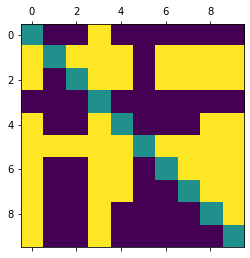

In [658]:
plt.matshow(preference[:10, :10])

In [659]:
service_with_index = [(i,v) for i,v in enumerate(preference.sum(axis=0))]

In [660]:
result = sorted(service_with_index, key=lambda t:t[1])[::-1][0:100]

In [661]:
actual = sorted(enumerate(TPMatrix.iloc[0, :].values), key=lambda t:t[1])[::-1][0:100]


In [662]:
def extractIndex(list):
    return [i for (i,v) in list];

In [663]:
len(np.intersect1d(extractIndex(result), extractIndex(actual)))

24